# Attention implementation for Dense Layer in Keras v2

reference: https://github.com/philipperemy/keras-attention-mechanism

In [1]:
import numpy as np
import keras
from keras.layers import *
from keras.models import *

Using TensorFlow backend.


In [2]:
INPUT_DIM = 2
TIME_STEPS = 20
SINGLE_ATTENTION_VECTOR = False # if True, the attention vector is shared across the input_dimentions where the attention is applied
APPLY_ATTENTION_BEFORE_LSTM = True

In [3]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_stamps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    #if SINGLE_ATTENTION_VECTOR:
    #    a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
    #    a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul

In [4]:
def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = Bidirectional(GRU(lstm_units, return_sequences=True), merge_mode='concat', weights=None)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [5]:
def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = Bidirectional(GRU(lstm_units, return_sequences=False), merge_mode='concat', weights=None)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [6]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

In [7]:
N = 300000
inputs, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)

In [8]:
    if APPLY_ATTENTION_BEFORE_LSTM:
        m = model_attention_applied_before_lstm()
    else:
        m = model_attention_applied_after_lstm()
        
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())
    
    m.fit([inputs], outputs, epochs=1, batch_size=64, validation_split=0.1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 2, 20)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 20)        0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2, 20)        420         reshape_1[0][0]                  
__________________________________________________________________________________________________
attention_

In [9]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    #print('----- activations -----')
    activations = []
    input_shape = model.input

    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name] # all layer outputs

    funcs = [K.function([input_shape] + [K.learning_phase()], [out]) for out in outputs] # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        #if print_shape_only:
        #    print(layer_activations.shape)
        #else:
        #print(layer_activations)
    return activations

In [10]:
attention_vectors = []
for i in range(300):
    testing_inputs, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
    attention_vector = np.mean(get_activations(m,
                                             testing_inputs,
                                             print_shape_only=True,
                                             layer_name='attention_vec')[0],
                               axis=2).squeeze()
    #print('attention =', attention_vector)
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)
    
attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

In [11]:
from matplotlib import pyplot as plt
import pandas as pd 

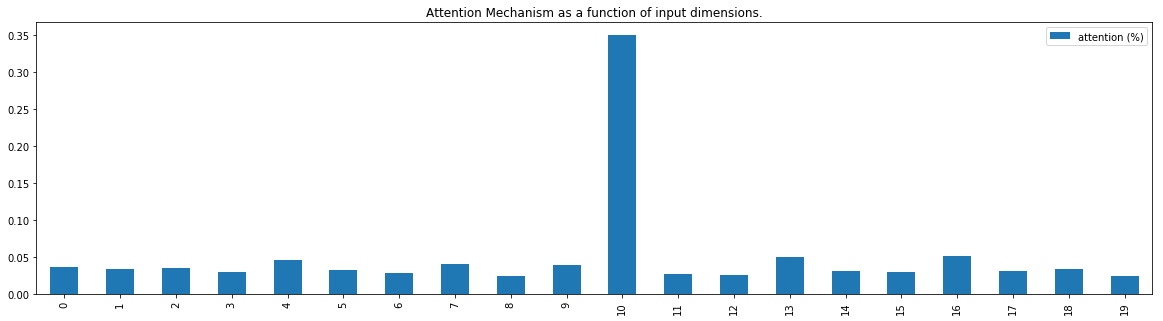

In [12]:
pd.DataFrame(attention_vector_final,
             columns=['attention (%)']).plot(kind='bar',
                                             title='Attention Mechanism as a function of input dimensions.',
                                             figsize=(20,5))